<a href="https://colab.research.google.com/github/nisha-s10/Deep-Learning-Lab-AFI524/blob/main/Experiment%207/Experiment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STEP 1 — IMPORT LIBRARIES

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import re
import time
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### STEP 2 — LOAD & PREPROCESS DATA

In [ ]:
file_path = "/kaggle/input/datasets/nishasin3110/spa-txt/spa.txt"

pairs = []
with open(file_path, encoding="utf-8") as f:
    for line in f:
        eng, spa = line.strip().split("\t")
        pairs.append((eng.lower(), spa.lower()))

pairs = pairs[:5000]

def clean_text(text):
    text = re.sub(r'[^a-zA-Z¿¡?.!,\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

pairs = [(clean_text(e), clean_text(s)) for e, s in pairs]

train_data, temp_data = train_test_split(pairs, test_size=0.2)
val_data, test_data = train_test_split(temp_data, test_size=0.5)

### STEP 3 — BUILD VOCABULARY

In [ ]:
def build_vocab(sentences):
    counter = Counter()
    for s in sentences:
        counter.update(s.split())

    vocab = {"<pad>":0, "<sos>":1, "<eos>":2, "<unk>":3}
    for word in counter:
        vocab[word] = len(vocab)
    return vocab

eng_vocab = build_vocab([e for e,s in pairs])
spa_vocab = build_vocab([s for e,s in pairs])

eng_vocab_size = len(eng_vocab)
spa_vocab_size = len(spa_vocab)

### STEP 4 — DATASET

In [ ]:
MAX_LEN = 15

class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def encode(self, sentence, vocab):
        tokens = [vocab.get(w, vocab["<unk>"]) for w in sentence.split()]
        tokens = tokens[:MAX_LEN-1]
        tokens.append(vocab["<eos>"])
        tokens += [vocab["<pad>"]] * (MAX_LEN - len(tokens))
        return torch.tensor(tokens)

    def __getitem__(self, idx):
        eng, spa = self.data[idx]
        src = self.encode(eng, eng_vocab)

        trg = [spa_vocab["<sos>"]]
        trg += self.encode(spa, spa_vocab).tolist()
        trg = trg[:MAX_LEN]
        trg += [spa_vocab["<pad>"]] * (MAX_LEN - len(trg))
        trg = torch.tensor(trg)

        return src, trg

    def __len__(self):
        return len(self.data)

train_loader = DataLoader(TranslationDataset(train_data),
                          batch_size=32, shuffle=True)

### STEP 5 — POSITIONAL ENCODING

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

### STEP 6 — SCALED DOT PRODUCT ATTENTION

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention, V)
        return output, attention

### STEP 7 — MULTI HEAD ATTENTION

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, heads):
        super().__init__()
        self.d_model = d_model
        self.heads = heads
        self.d_k = d_model // heads

        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention()

    def forward(self, Q, K, V, mask=None):

        batch_size = Q.size(0)

        Q_len = Q.size(1)
        K_len = K.size(1)
        V_len = V.size(1)

        # Linear projections
        Q = self.WQ(Q).view(batch_size, Q_len, self.heads, self.d_k)
        K = self.WK(K).view(batch_size, K_len, self.heads, self.d_k)
        V = self.WV(V).view(batch_size, V_len, self.heads, self.d_k)

        # Transpose for attention
        Q = Q.transpose(1, 2)  # (batch, heads, Q_len, d_k)
        K = K.transpose(1, 2)  # (batch, heads, K_len, d_k)
        V = V.transpose(1, 2)  # (batch, heads, V_len, d_k)

        if mask is not None:
            mask = mask.expand(batch_size, self.heads, -1, -1)

        out, attention = self.attention(Q, K, V, mask)

        # Restore shape
        out = out.transpose(1, 2).contiguous()
        out = out.view(batch_size, Q_len, self.d_model)

        return self.fc(out)

### STEP 8 — ENCODER LAYER

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff=512):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        attn = self.attn(x, x, x, mask)
        x = self.norm1(x + attn)
        ff = self.ff(x)
        x = self.norm2(x + ff)
        return x

### STEP 9 — DECODER LAYER

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff=512):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, heads)
        self.norm1 = nn.LayerNorm(d_model)

        self.cross_attn = MultiHeadAttention(d_model, heads)
        self.norm2 = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_out, src_mask, trg_mask):
        self_attn = self.self_attn(x, x, x, trg_mask)
        x = self.norm1(x + self_attn)

        cross_attn = self.cross_attn(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + cross_attn)

        ff = self.ff(x)
        x = self.norm3(x + ff)

        return x

### STEP 10 — FULL TRANSFORMER

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim,
                 d_model=128, heads=4,
                 num_layers=2):

        super().__init__()

        self.src_embed = nn.Embedding(input_dim, d_model)
        self.trg_embed = nn.Embedding(output_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, heads) for _ in range(num_layers)]
        )

        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, heads) for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(d_model, output_dim)

    def make_src_mask(self, src):
        # src: (batch, seq_len)
        mask = (src != 0).unsqueeze(1).unsqueeze(2)
        # shape: (batch, 1, 1, seq_len)
        return mask

    def make_trg_mask(self, trg):
        batch_size, trg_len = trg.shape

        pad_mask = (trg != 0).unsqueeze(1).unsqueeze(2)
        # (batch, 1, 1, trg_len)

        causal_mask = torch.tril(
            torch.ones((trg_len, trg_len), device=device)
        ).bool()

        causal_mask = causal_mask.unsqueeze(0).unsqueeze(1)
        # (1, 1, trg_len, trg_len)

        return pad_mask & causal_mask

    def forward(self, src, trg):

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        src = self.pos_enc(self.src_embed(src))
        trg = self.pos_enc(self.trg_embed(trg))

        enc_out = src
        for layer in self.encoder_layers:
            enc_out = layer(enc_out, src_mask)

        dec_out = trg
        for layer in self.decoder_layers:
            dec_out = layer(dec_out, enc_out, src_mask, trg_mask)

        return self.fc_out(dec_out)

### STEP 11 — TRAINING

Epoch 1, Loss: 5.614777656555176
Epoch 2, Loss: 4.358563533782959
Epoch 3, Loss: 3.60332785987854
Epoch 4, Loss: 3.0199887294769288
Epoch 5, Loss: 2.507005563735962
Epoch 6, Loss: 2.054099702835083
Epoch 7, Loss: 1.6614342002868652
Epoch 8, Loss: 1.322195728302002
Epoch 9, Loss: 1.0324101390838623
Epoch 10, Loss: 0.7851437129974366
Training Time: 103.84647178649902


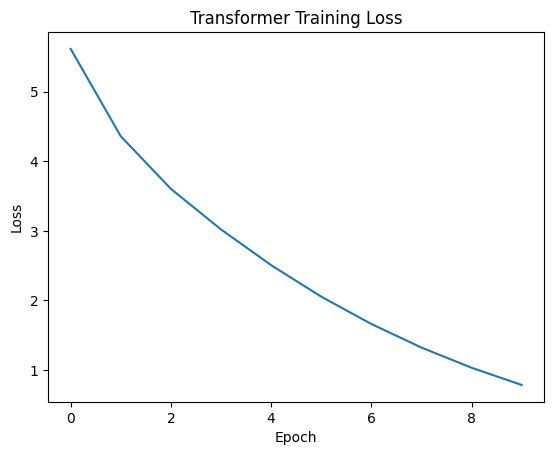

In [ ]:
model = Transformer(
    eng_vocab_size,
    spa_vocab_size,
    d_model=128,
    heads=4,
    num_layers=2,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=0)

def train_model(epochs=10):
    model.train()
    losses=[]
    for epoch in range(epochs):
        total_loss = 0
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()

            output = model(src, trg[:,:-1])

            loss = criterion(
                output.reshape(-1, spa_vocab_size),
                trg[:,1:].reshape(-1)
            )

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_loss = total_loss / len(train_loader)
        losses.append(epoch_loss)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

    return losses

start = time.time()
losses = train_model()
end = time.time()

print("Training Time:", end-start)

plt.plot(losses)
plt.title("Transformer Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### STEP 12 — BLEU EVALUATION

Transformer BLEU: 0.03472529211611848

===== BLEU SCORE COMPARISON =====
Model               BLEU Score
------------------------------
Vanilla LSTM        0.0189
Bahdanau Attention  0.0230
Luong Attention     0.0216
Transformer         0.0347


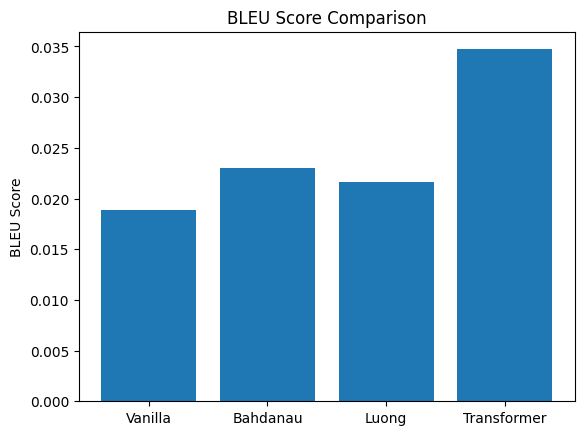

In [ ]:
def evaluate_bleu(model, test_data):
    model.eval()
    smooth = SmoothingFunction().method1
    scores = []

    with torch.no_grad():
        dataset = TranslationDataset(test_data)

        for src, trg in dataset:
            src = src.unsqueeze(0).to(device)
            trg = trg.unsqueeze(0).to(device)

            output = model(src, trg[:,:-1])
            pred = output.argmax(2).squeeze().tolist()
            reference = trg[:,1:].squeeze().tolist()

            score = sentence_bleu(
                [reference],
                pred,
                smoothing_function=smooth
            )

            scores.append(score)

    return np.mean(scores)

bleu_transformer = evaluate_bleu(model, test_data)

print("Transformer BLEU:", bleu_transformer)

bleu_vanilla = 0.0189   # from Exp 6
bleu_bahdanau = 0.0230  # from Exp 6
bleu_luong = 0.0216     # from Exp 6

print("\n===== BLEU SCORE COMPARISON =====")
print(f"{'Model':<20}{'BLEU Score'}")
print("-" * 30)
print(f"{'Vanilla LSTM':<20}{bleu_vanilla:.4f}")
print(f"{'Bahdanau Attention':<20}{bleu_bahdanau:.4f}")
print(f"{'Luong Attention':<20}{bleu_luong:.4f}")
print(f"{'Transformer':<20}{bleu_transformer:.4f}")

models = ["Vanilla", "Bahdanau", "Luong", "Transformer"]
scores = [bleu_vanilla, bleu_bahdanau, bleu_luong, bleu_transformer]

plt.bar(models, scores)
plt.title("BLEU Score Comparison")
plt.ylabel("BLEU Score")
plt.show()

### Example Translation Outputs

#### Helper: Decode Tokens

In [ ]:
def decode_tokens(tokens, vocab):
    inv_vocab = {v:k for k,v in vocab.items()}
    words = []

    for t in tokens:
        if t == vocab["<eos>"] or t == vocab["<pad>"]:
            break
        words.append(inv_vocab.get(t, "<unk>"))

    return words

#### Translation Function

In [ ]:
def translate_sentence(model, sentence):
    model.eval()

    dataset = TranslationDataset([(sentence, "")])
    src, _ = dataset[0]
    src = src.unsqueeze(0).to(device)

    trg_indices = [spa_vocab["<sos>"]]

    for _ in range(MAX_LEN):

        trg_tensor = torch.tensor([trg_indices], dtype=torch.long).to(device)

        with torch.no_grad():
            output = model(src, trg_tensor)

        next_token = output.argmax(2)[:, -1].item()

        if next_token == spa_vocab["<eos>"]:
            break

        trg_indices.append(next_token)

    translated = decode_tokens(trg_indices[1:], spa_vocab)

    return " ".join(translated)

#### Print Example Translations

In [ ]:
print("\n===== Example Translation Output (Transformer) =====\n")

example_sentence = test_data[0][0]

print("Source:", example_sentence)
print("\nPredicted:", translate_sentence(model, example_sentence))


===== Example Translation Output (Transformer) =====

Source: im next.

Predicted: soy listo.
